# Samples analysis
Analyse cosmological model posterior samples.

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.6' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, config as jconfig, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)

from functools import partial
from getdist import plots
from numpyro import infer

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save
from montecosmo.script import from_id, get_mcmc, get_init_mcmc

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")deformed
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname

feynmangpu04.cluster.local


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Config and fiduc

In [3]:
################## TO SET #######################
# task_id = int(os.environ['SLURM_ARRAY_TASK_ID'])
task_id = 3133
print("SLURM_ARRAY_TASK_ID:", task_id)
model, mcmc_config, save_dir, save_path = from_id(task_id)
os.makedirs(save_dir, exist_ok=True)

# import sys
# tempstdout, tempstderr = sys.stdout, sys.stderr
# sys.stdout = sys.stderr = open(save_path+'.out', 'a')
# job_id = int(os.environ['SLURM_ARRAY_JOB_ID'])
# print("SLURM_ARRAY_JOB_ID:", job_id)
# print("SLURM_ARRAY_TASK_ID:", task_id)

SLURM_ARRAY_TASK_ID: 3133


IndexError: list index out of range

In [3]:
print(model)
print(mcmc_config)
# model.render()

if not os.path.exists(save_dir+"truth.p"):
    # Predict and save fiducial
    truth = {'Omega_m': 0.31, 
            'sigma8': 0.81, 
            'b1': 1., 
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}

    model.reset()
    truth = model.predict(samples=truth, hide_base=False, hide_samp=False, frombase=True)
    
    print(f"Saving model and truth at {save_dir}")
    model.save(save_dir)    
    pdump(truth, save_dir+"truth.p")
else:
    print(f"Loading truth from {save_dir}")
    truth = pload(save_dir+"truth.p")

model.condition({'obs': truth['obs']})
model.block()
# model.render()

# CONFIG
{'a_lpt': 0.5,
 'a_obs': 0.5,
 'box_shape': array([320., 320., 320.]),
 'gxy_density': 0.001,
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'low': 0.05,
                         'scale': 0.2},
             'b1': {'group': 'bias',
                    'label': '{b}_1',
                    'loc': 1.0,
                    'scale': 0.5},
             'b2': {'group': 'bias',
                    'label': '{b}_2',
                    'loc': 0.0,
                    'scale': 2.0},
             'bn2': {'group': 'bias',
                     'label': '{b}_{\\nabla^2}',
                     'loc': 0.0,
                     'scale': 2.0},
             'bs2': {'group': 'bias',
                     'label': '{b}_{s^2}',
                     'loc': 0.0,
                     'scale': 2.0},
             'init_mesh': {'group': 'init',
               

2025-01-31 16:23:18.228437: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [ ]:
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh, theme
theme()
ils = pload(save_path+"_init_last_state.p").z
ls = pload(save_path+"_last_state.p").z # .z for numpyro, .position for blackjax
# ls = pload(save_path+"_last_state.p").position # .z, .position
# ls = pload(save_path+"_last_state.p")['mesh_'].position

mesh0 = jnp.fft.irfftn(truth['init_mesh'])
init_params_ = jit(vmap(model.kaiser_post))(jr.split(jr.key(43), mcmc_config['n_chains']))
print(init_params_.keys(), ils.keys(), ls.keys())

kptcs__ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_)
kptcs_ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_ | ils)
kptcs = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_ | ls)
kpk0 = model.spectrum(mesh0)
kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)
kpkobs = model.spectrum(truth['obs']-1)

mse__ = jnp.mean((vmap(lambda x: model.reparam(x, fourier=False))(init_params_)['init_mesh']  - mesh0)**2, axis=(1,2,3))
mse_ = jnp.mean((vmap(lambda x: model.reparam(x, fourier=False))(init_params_ | ils)['init_mesh']  - mesh0)**2, axis=(1,2,3))
mse = jnp.mean((vmap(lambda x: model.reparam(x, fourier=False))(init_params_ | ls)['init_mesh']  - mesh0)**2, axis=(1,2,3))
print("MSEs:", mse__, mse_, mse)

prob = 0.95
log = False
plt.figure(figsize=(12, 4))
plot_powtranscoh(*jnp.median(jnp.stack(kptcs__), 1), log=log, label='init')
plot_powtranscoh(*kptcs__, log=log, fill=prob)
plot_powtranscoh(*jnp.median(jnp.stack(kptcs_), 1), log=log, label='warm')
plot_powtranscoh(*kptcs_, log=log, fill=prob)
plot_powtranscoh(*jnp.median(jnp.stack(kptcs), 1), log=log, label='last')
plot_powtranscoh(*kptcs, log=log, fill=prob)
plt.subplot(131)
plot_pow(*kpk0, 'k', log=log, label='true')
plot_pow(*kpkobs, 'k:', log=log, label='obs')
plt.legend()
plt.subplot(133)
plot_coh(kptc_obs[0], kptc_obs[-1], ':', log=log, c='grey', label='obs')
plt.tight_layout()
plt.savefig(save_dir+f'init_glin_last_{task_id}.png')

# ils = pload(save_path+"_init_last_state.p")
# ls = pload(save_path+"_last_state.p")
# print("Init mean_acc_prob:", ils.mean_accept_prob, 
#         "\nss:", ils.adapt_state.step_size, 
#         "\nmm_sqrt:", ils.adapt_state.mass_matrix_sqrt)
# print("Last mean_acc_prob:", ls.mean_accept_prob, 
#         "\nss:", ls.adapt_state.step_size, 
#         "\nmm_sqrt:", ls.adapt_state.mass_matrix_sqrt)

## Analysis

In [3]:
from montecosmo.mcbench import Chains
task_id = 3140
model, mcmc_config, save_dir, save_path = from_id(task_id)
print(f"Loading truth from {save_dir}")
truth = pload(save_dir+"truth.p")
print("save path:", save_path)

Loading truth from /feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_al0.5_ao0.5_lo1_pc4_obfield/
save path: /feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_al0.5_ao0.5_lo1_pc4_obfield/sNUTS_nc4_ns64_mt10_ta0.65


2025-02-04 16:38:34.144807: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
from montecosmo.mcbench import Chains, Samples
from montecosmo.plot import theme, SetDark2, plot_pow, plot_powtranscoh, plot_coh
theme(usetex=True, font_size=14)
mesh0 = jnp.fft.irfftn(truth['init_mesh'])
pow0 = model.spectrum(mesh0)
kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)

transforms = [
              lambda x:x[['*~diverging']],                          # load every variables except diverging boolean
              partial(Chains.thin, thinning=1),                     # thin the chains
              model.reparam_chains,                                 # reparametrize sample variables into base variables
              partial(model.powtranscoh_chains, mesh0=mesh0),       # compute mesh statistics
              partial(Chains.choice, n=10, names=['init','init_']), # subsample mesh 
              ]
chains = model.load_runs(save_path, 1, 11, transforms=transforms, batch_ndim=2)
groups = ['cosmo','bias','init']
chains.shape

Loading: sNUTS_nc4_ns64_mt10_ta0.65, from run 1 to run 11 (included)
File /feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_al0.5_ao0.5_lo1_pc4_obfield/sNUTS_nc4_ns64_mt10_ta0.65_11.npz does not exist, stopping at run 10


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


{'Omega_m': (4, 640),
 'b1': (4, 640),
 'b2': (4, 640),
 'bn2': (4, 640),
 'bs2': (4, 640),
 'init_mesh': (4, 640, 10),
 'kptc': ((4, 640, 15), (4, 640, 15), (4, 640, 15), (4, 640, 15)),
 'n_evals': (4, 640),
 'sigma8': (4, 640)}

/feynman/home/dphp/hs276503/workspace/montecosmo_proj/src/montecosmo/montecosmo/mcbench.py:542: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  subfig.subplots_adjust(wspace=0)
/feynman/home/dphp/hs276503/workspace/montecosmo_proj/src/montecosmo/montecosmo/mcbench.py:542: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  subfig.subplots_adjust(wspace=0)



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
init_mesh[0]      2.41      1.35      2.39      0.04      4.50   1762.50      1.00
init_mesh[1]      0.31      1.34      0.29     -1.92      2.46   1843.02      1.00
init_mesh[2]      0.74      1.45      0.73     -1.81      2.96   1825.26      1.00
init_mesh[3]     -0.41      1.55     -0.40     -2.99      2.03   1576.03      1.00
init_mesh[4]      0.20      1.61      0.22     -2.45      2.86   1457.65      1.00
init_mesh[5]     -0.04      1.53      0.01     -2.50      2.44   1592.01      1.00
init_mesh[6]      1.72      1.30      1.72     -0.38      3.88   1954.69      1.00
init_mesh[7]     -0.18      1.40     -0.20     -2.49      2.16   1513.15      1.00
init_mesh[8]      1.89      1.33      1.91     -0.21      4.11   1557.77      1.00
init_mesh[9]     -0.30      1.48     -0.28     -2.78      2.00   1768.35      1.00
         bs2     -0.00      0.09     -0.01     -0.16      0.13     25.09      1.15
   

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


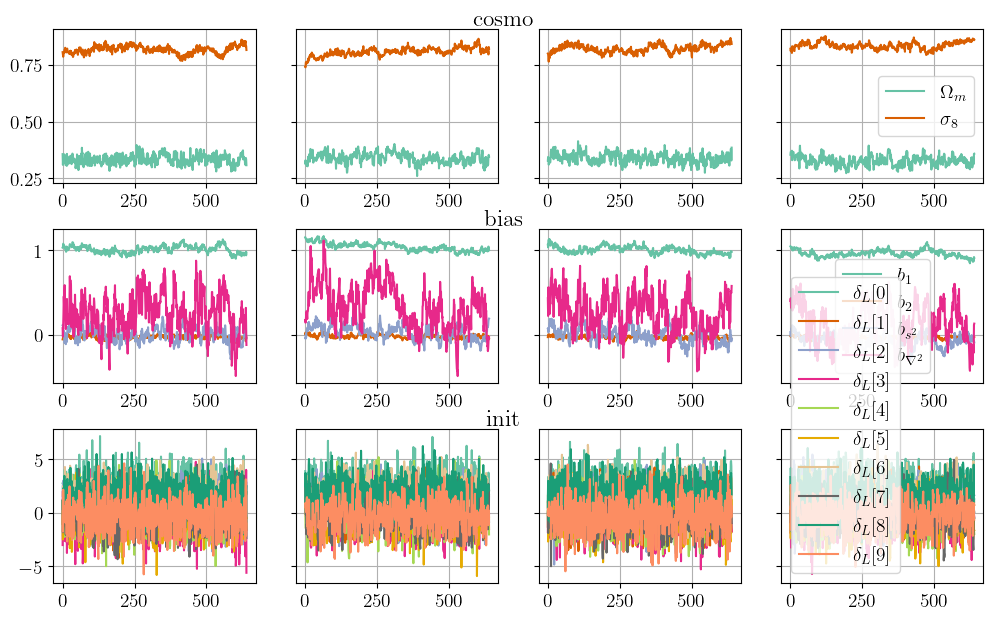

In [5]:
plt.figure(figsize=(12,6), layout="constrained")
chains[['*~kptc']].flatten().plot(groups, batch_ndim=2)
chains[['*~kptc']].print_summary()

Removed no burn in


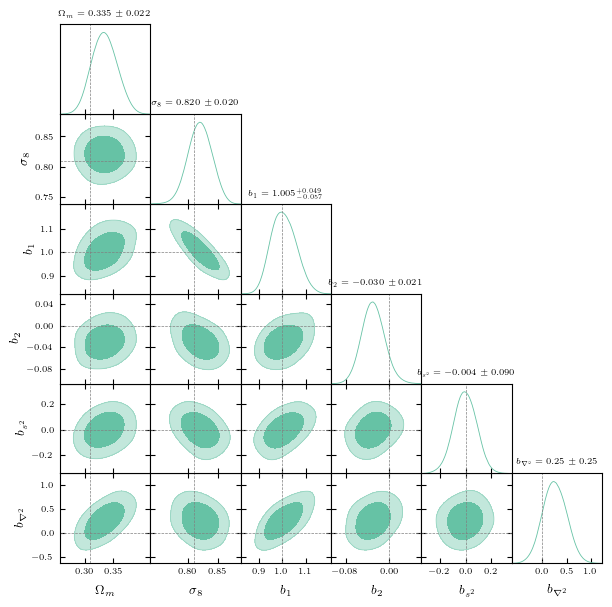

In [6]:
gdsamp = chains[['cosmo','bias']].to_getdist()
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)])

# gdsamp = chains[['init']].flatten().to_getdist()
# gdplt = plots.get_subplot_plotter(width_inch=7)
# gdplt.triangle_plot(roots=[gdsamp],
#                 title_limit=1,
#                 filled=True, 
#                 markers=truth,
#                 contour_colors=[SetDark2(0)])

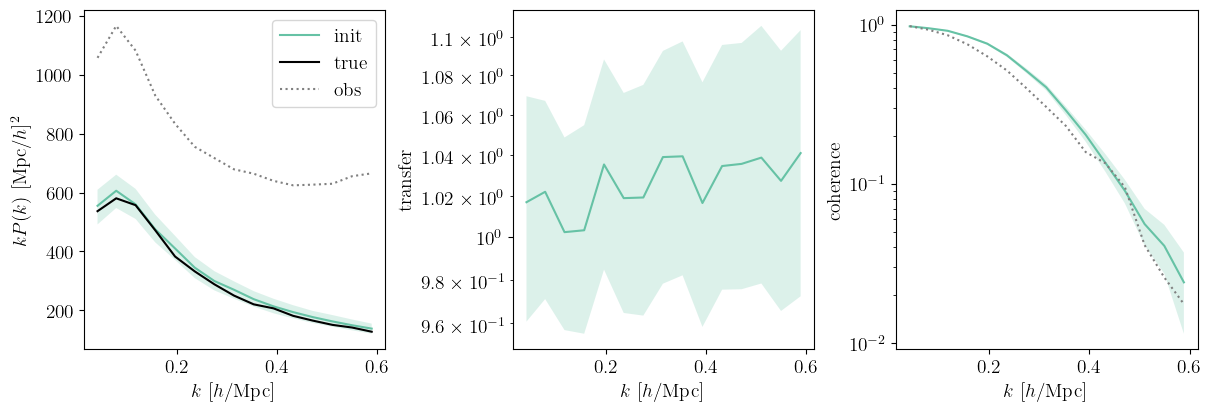

In [7]:
prob = 0.95
log = False

plt.figure(figsize=(12, 4), layout="constrained")
kptcs = tree.map(jnp.concatenate, chains['kptc'])
plot_powtranscoh(*jnp.median(jnp.stack(kptcs), 1), log=log, label='init')
plot_powtranscoh(*kptcs, log=log, fill=prob)

plt.subplot(131)
plot_pow(*pow0, 'k', log=log, label='true')
plot_pow(*kptc_obs[:2], ':', c='grey', log=log, label='obs')
plt.legend()

plt.subplot(133)
plot_coh(kptc_obs[0], kptc_obs[-1], ':', log=log, c='grey', label='obs')
_ = chains.pop('kptc')

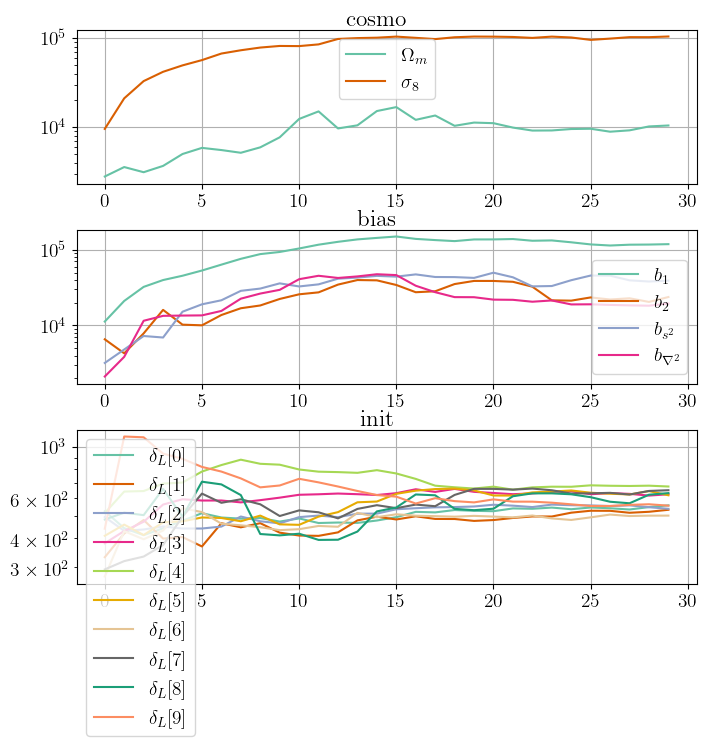

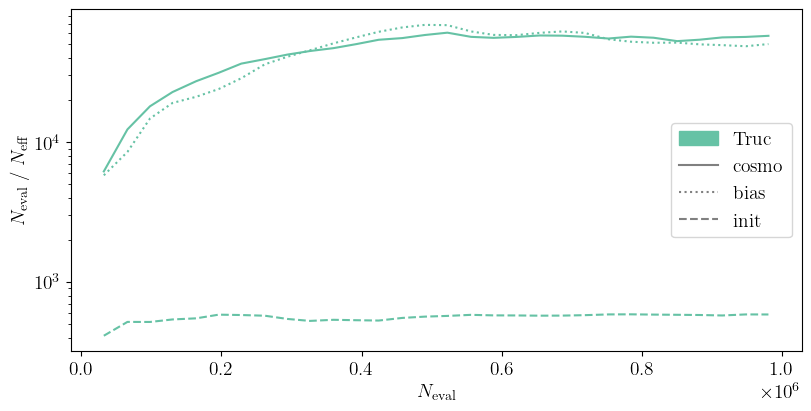

In [8]:
plt.figure(figsize=(8, 6))
chains.flatten().cumtrans(Chains.eval_per_ess, 30).plot(groups, 1, log=True)

labels = ['Truc']
metrics = []
cumess = chains.stackby(groups).cumtrans(Chains.eval_per_ess, 30)
metrics.append(cumess)

def plot_fn(metrics, labels):
    plt.figure(figsize=(8, 4), layout="constrained")
    i_start = 0
    styles = ['-', ':', '--']
    for i_m, (metric, meth) in enumerate(zip(metrics, labels)):
        for i_g, (st, g) in enumerate(zip(styles, groups)):
            plt.semilogy(metric['n_evals'][i_start:], metric[g][i_start:], st, c=SetDark2(i_m), label=g)

    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    handles = []
    for i_m, method in enumerate(labels):
        handles.append(Patch(color=SetDark2(i_m), label=method))
    for i_g, g in enumerate(groups):
        handles.append(Line2D([], [], color='grey', linestyle=styles[i_g], label=g))

    plt.legend(handles=handles);

plot_fn(metrics, labels)
plt.xlabel("$N_{\\mathrm{eval}}$")
plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$");

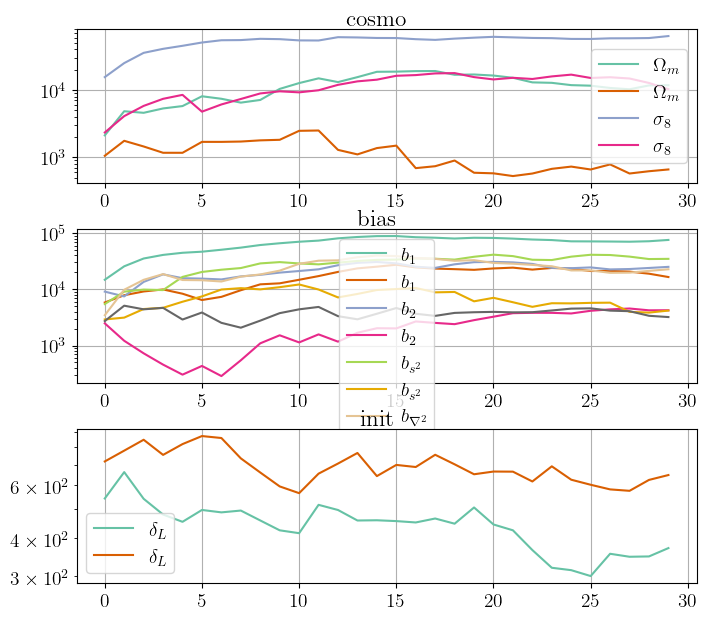

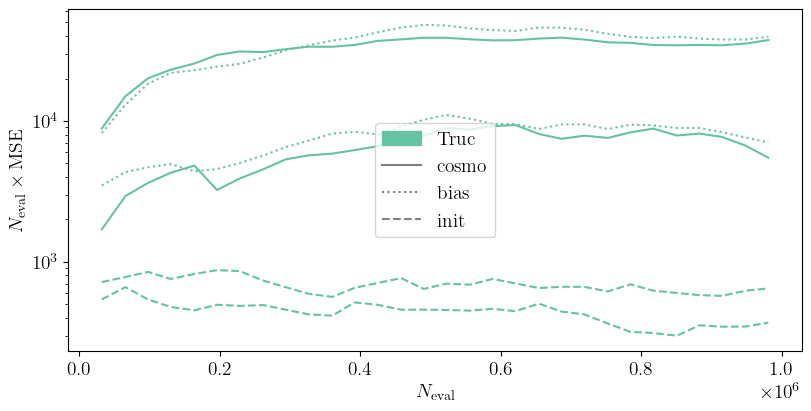

In [9]:
plt.figure(figsize=(8, 6))
true_cmom = chains.moment(axis=(0,1)).center_moment()
fn = lambda x: Chains.eval_times_mse(x, true_cmom)
chains.cumtrans(fn, 30).plot(groups, 1, log=True)

metrics = []
true_cmom = chains.stackby(groups).moment(axis=(0,1)).center_moment()
fn = lambda x: Chains.eval_times_mse(x, true_cmom)
cummse = chains.stackby(groups).cumtrans(fn, 30)
metrics.append(cummse)

plot_fn(metrics, labels)
plt.xlabel("$N_{\\mathrm{eval}}$")
plt.ylabel("$N_{\\mathrm{eval}} \\times \\mathrm{MSE}$");

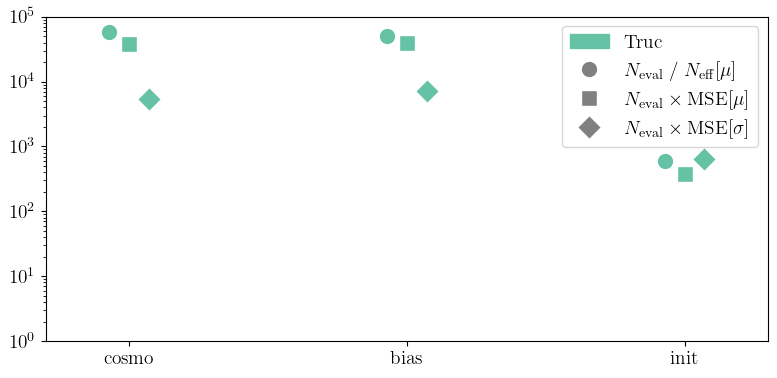

In [11]:
metrics = []
cumess = chains.stackby(groups).eval_per_ess()
cummse = chains.stackby(groups).eval_times_mse(true_cmom)
metric = tree.map(lambda x, y: jnp.concatenate((x[None], y)), cumess[['*~n_evals']], cummse[['*~n_evals']])
metrics.append(metric)

labels = ['Truc']
markers = ['o','s','D']
ms = 12
mec = 'w'
ls = ""
metric_names = [
                # "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$",
                "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}[\\mu]$",
                "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\mu]$",
                "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\sigma]$"]

plt.figure(figsize=(8, 4))
from matplotlib.transforms import ScaledTranslation
offset = lambda mm: ScaledTranslation(mm/25.4, 0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData
xshifts = 5*np.array([-1,0,1])
plt.xlim(-.3,2.3), plt.ylim((1e0, 1e5))

for i_m, (metric, meth) in enumerate(zip(metrics, labels)):
    for i_g, g in enumerate(groups):
        for i_n, marker in enumerate(markers):
            plt.semilogy(g, metric[g][i_n], marker, c=SetDark2(i_m),
                         linestyle=ls, markersize=ms, markeredgecolor=mec, 
                         transform=trans+offset(xshifts[i_n])
                         )

handles = []
from matplotlib.lines import Line2D; from matplotlib.patches import Patch
for i_m, label in enumerate(labels):
    handles.append(Patch(color=SetDark2(i_m), label=label))
for i_m, (marker, name) in enumerate(zip(markers, metric_names)):
    handles.append(Line2D([], [], color='grey', marker=marker, label=name, 
                           linestyle=ls, markersize=ms, markeredgecolor=mec))

plt.legend(handles=handles, loc="upper right")
plt.tight_layout();

## Example


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     Omega_m      0.31      0.15      0.29      0.10      0.57     64.11      1.01
          b1      1.06      0.52      1.01      0.10      1.85     99.76      1.00
          b2      0.07      2.06      0.17     -3.59      2.94     89.42      1.00
         bn2     -0.30      1.78     -0.11     -3.40      2.19     87.39      1.00
         bs2      0.11      1.68     -0.02     -2.80      2.67    121.15      0.99
init_mesh[0]      0.10      1.70      0.25     -2.29      2.85    126.55      1.00
init_mesh[1]     -0.08      1.54     -0.13     -1.81      3.12    134.99      1.01
init_mesh[2]      0.07      1.59     -0.04     -2.74      2.50    119.47      0.98
init_mesh[3]     -0.11      1.49     -0.04     -2.75      1.88    207.53      1.00
init_mesh[4]     -0.05      1.81     -0.02     -2.85      3.22    127.23      0.99
init_mesh[5]     -0.33      1.46     -0.25     -2.38      2.12    113.33      0.99
ini

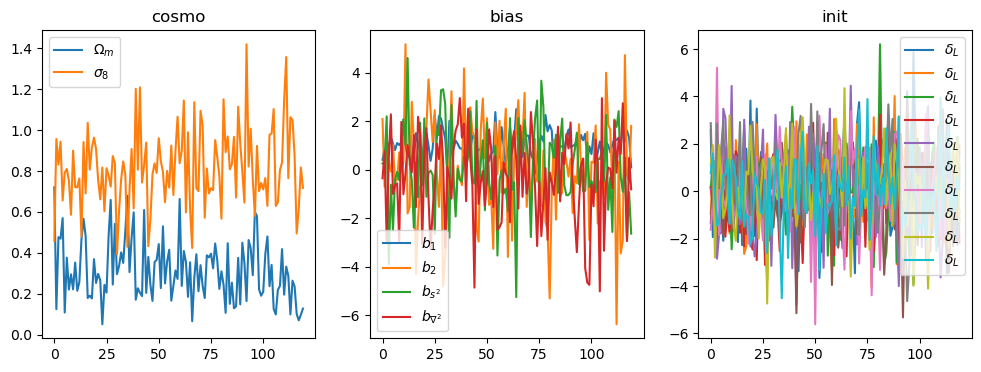

In [ ]:
plt.figure(figsize=(12,4))
chains.plot(groups)
chains.print_summary()

Removed no burn in


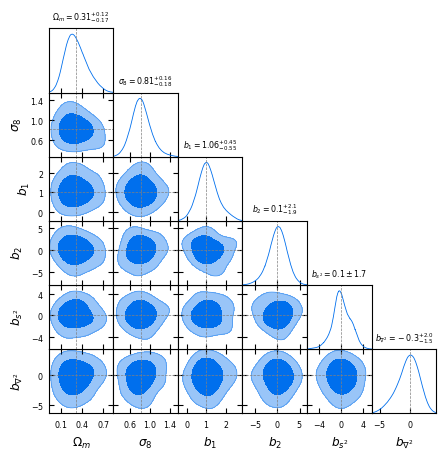

In [ ]:
gdsamp = chains[['cosmo','bias']].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=5)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,)

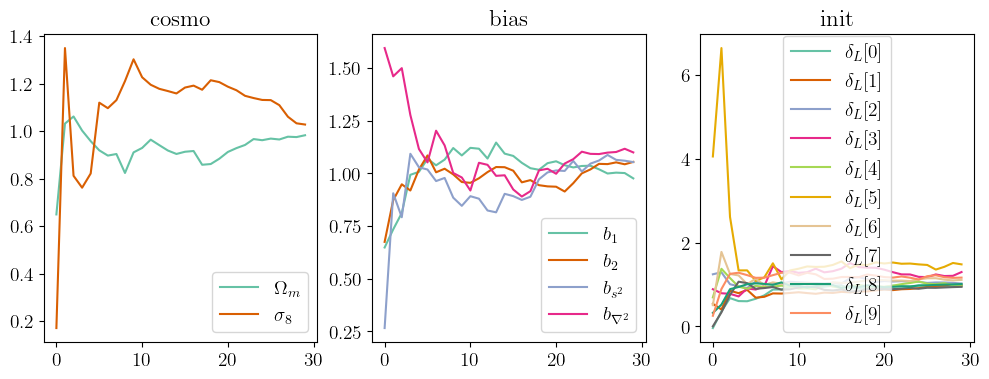

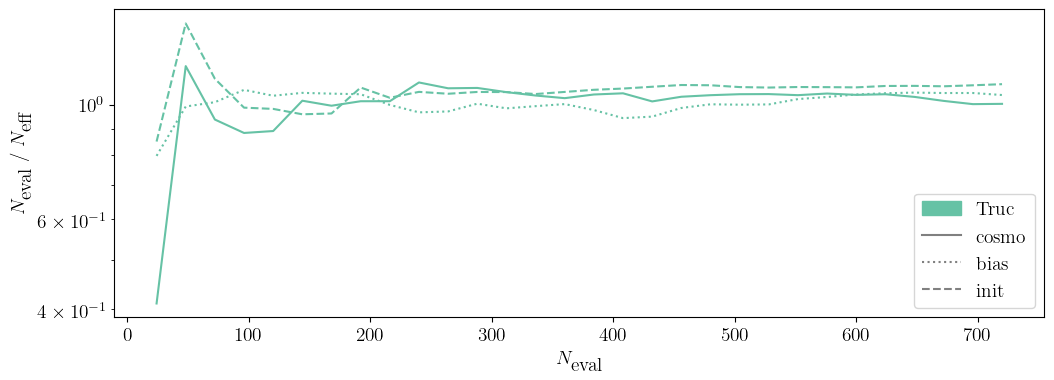

In [60]:
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)
plt.figure(figsize=(12, 4))
chains.flatten().cumtrans(Chains.eval_per_ess, 30).plot(groups, 1)

metrics = []
cumess = chains.stackby(groups).cumtrans(Chains.eval_per_ess, 30)
metrics.append(cumess)

def plot_fn():
    plt.figure(figsize=(12, 4))
    methods = ['Truc']
    i_start = 0
    styles = ['-', ':', '--']
    for i_m, (metric, meth) in enumerate(zip(metrics, methods)):
        for i_g, (st, g) in enumerate(zip(styles, groups)):
            plt.semilogy(metric['n_evals'][i_start:], metric[g][i_start:], st, c=SetDark2(i_m), label=g)

    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    handles = []
    for i_m, method in enumerate(methods):
        handles.append(Patch(color=SetDark2(i_m), label=method))
    for i_g, g in enumerate(groups):
        handles.append(Line2D([], [], color='grey', linestyle=styles[i_g], label=g))

    plt.legend(handles=handles);

plot_fn()
plt.xlabel("$N_{\\mathrm{eval}}$")
# plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;\\mathrm{ESS}$")
plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$");

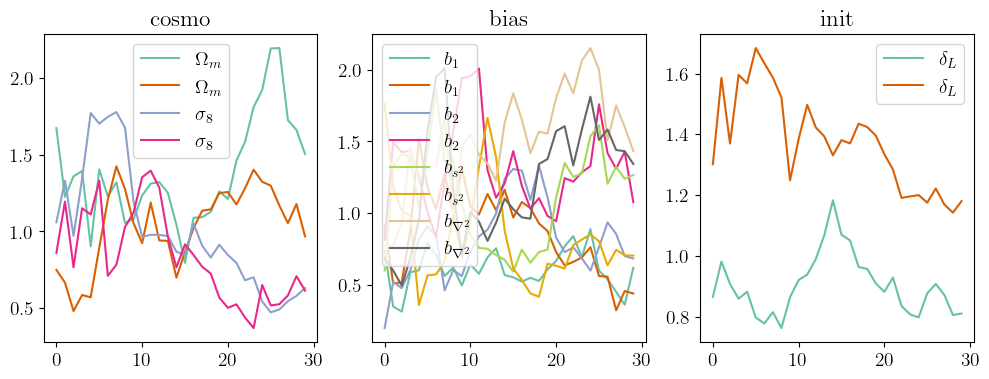

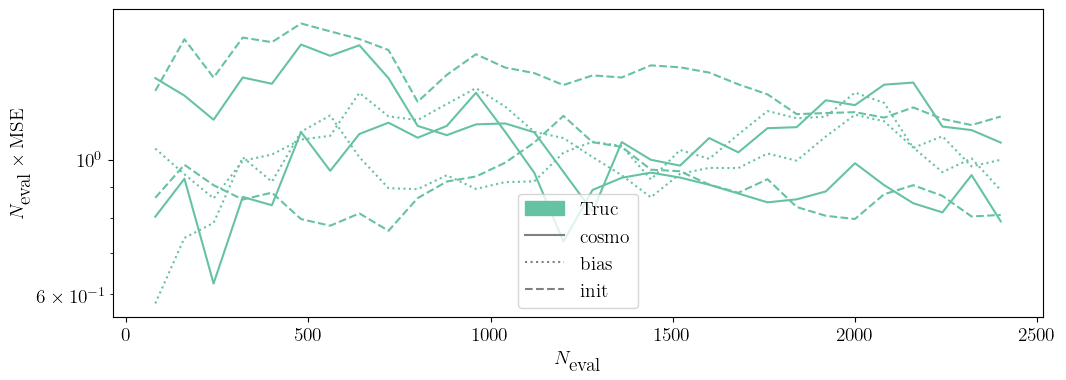

In [97]:
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)

plt.figure(figsize=(12, 4))
true_cmom = chains.moment(axis=(0,1)).center_moment()
fn = lambda x: Chains.eval_times_mse(x, true_cmom)
chains.cumtrans(fn, 30).plot(groups, 1)

metrics = []
true_cmom = chains.stackby(groups).moment(axis=(0,1)).center_moment()
fn = lambda x: Chains.eval_times_mse(x, true_cmom)
cummse = chains.stackby(groups).cumtrans(fn, 30)
metrics.append(cummse)

plot_fn()
plt.xlabel("$N_{\\mathrm{eval}}$")
plt.ylabel("$N_{\\mathrm{eval}} \\times \\mathrm{MSE}$");

<Figure size 1200x400 with 0 Axes>

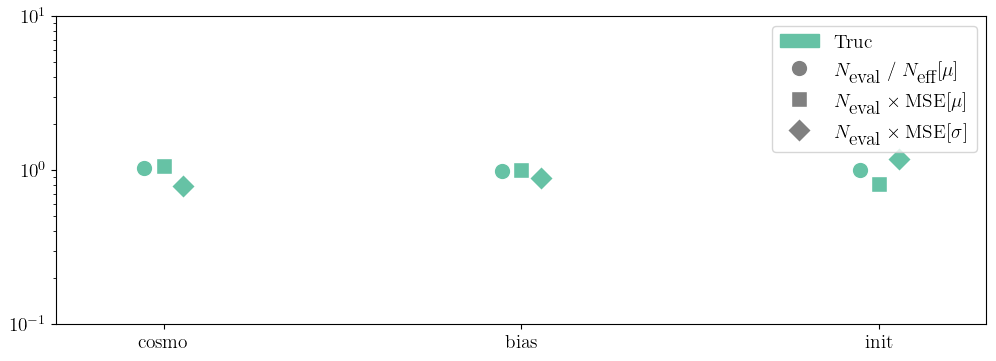

In [98]:
from montecosmo.plot import theme, SetDark2
theme(usetex=True, font_size=14)
plt.figure(figsize=(12, 4))

metrics = []
cumess = chains.stackby(groups).eval_per_ess()
cummse = chains.stackby(groups).eval_times_mse(true_cmom)
metric = tree.map(lambda x, y: jnp.concatenate((x[None], y)), cumess[['*~n_evals']], cummse[['*~n_evals']])
metrics.append(metric)

plt.figure(figsize=(12, 4))
labels = ['Truc']
markers = ['o','s','D']
ms = 12
mec = 'w'
ls = ""
metric_names = [
                # "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$",
                "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}[\\mu]$",
                "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\mu]$",
                "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\sigma]$"]
# metric_names = ["ESS", "MSE[$\\mu$]", "MSE[$\\sigma$]"]

from matplotlib.transforms import ScaledTranslation
offset = lambda mm: ScaledTranslation(mm/25.4, 0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData
xshifts = 5*np.array([-1,0,1])
plt.xlim(-.3,2.3), plt.ylim((1e0, 1e5))

for i_m, (metric, meth) in enumerate(zip(metrics, labels)):
    for i_g, g in enumerate(groups):
        for i_n, marker in enumerate(markers):
            plt.semilogy(g, metric[g][i_n], marker, c=SetDark2(i_m),
                         linestyle=ls, markersize=ms, markeredgecolor=mec, 
                         transform=trans+offset(xshifts[i_n])
                         )

handles = []
from matplotlib.lines import Line2D; from matplotlib.patches import Patch
for i_m, label in enumerate(labels):
    handles.append(Patch(color=SetDark2(i_m), label=label))
for i_m, (marker, name) in enumerate(zip(markers, metric_names)):
    handles.append(Line2D([], [], color='grey', marker=marker, label=name, 
                           linestyle=ls, markersize=ms, markeredgecolor=mec))

plt.legend(handles=handles, loc="upper right");

# Comparison

True id: 3112040
/feynman/home/dphp/hs276503/scratch/pickles/precond/m64_b320.0_ao0.5_evlpt_lo1_pcdirect_obfield/sMCLMC_nc8_ns128_nomm
{'Omega_m': (8, 3712), 'b1': (8, 3712), 'b2': (8, 3712), 'bn2': (8, 3712), 'bs2': (8, 3712), 'init_mesh': (8, 3712, 100), 'mse_per_dim': (8, 3712), 'n_evals': (8, 3712), 'sigma8': (8, 3712)} 

Chains(data={'Omega_m': Array(0.01682403, dtype=float64), 'b1': Array(0.04444626, dtype=float64), 'b2': Array(0.02171098, dtype=float64), 'bn2': Array(0.23220604, dtype=float64), 'bs2': Array(0.08746325, dtype=float64), 'init_mesh': Array(1.58979072, dtype=float64), 'mse_per_dim': Array(4.94325693e-08, dtype=float64), 'n_evals': Array(0., dtype=float64), 'sigma8': Array(0.01612895, dtype=float64)}, groups={'cosmo': ['Omega_m', 'sigma8'], 'bias': ['b1', 'b2', 'bs2', 'bn2'], 'init': ['init_mesh'], 'cosmo_': ['Omega_m_', 'sigma8_'], 'bias_': ['b1_', 'b2_', 'bs2_', 'bn2_'], 'init_': ['init_mesh_']}, labels={'Omega_m': '{\\Omega}_m', 'Omega_m_': '\\tilde{\\Omega}_m', '

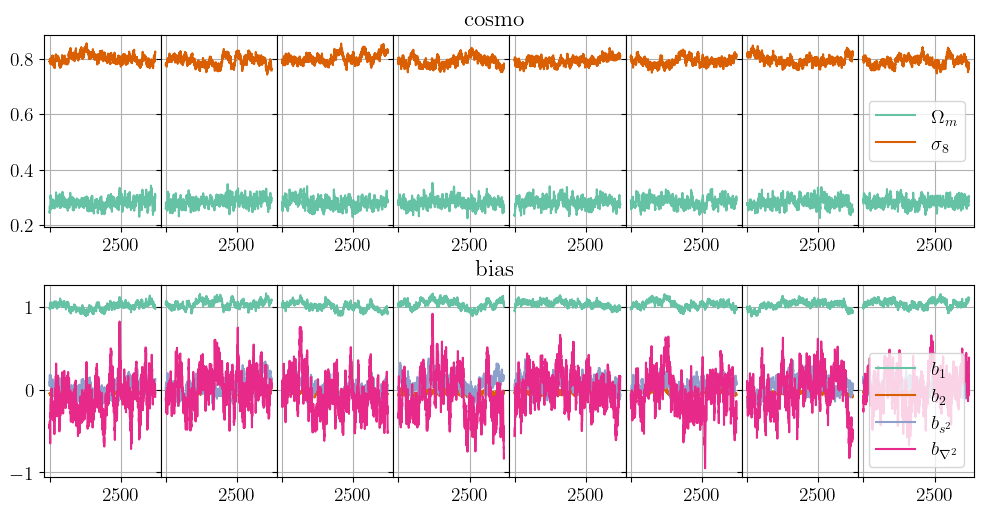

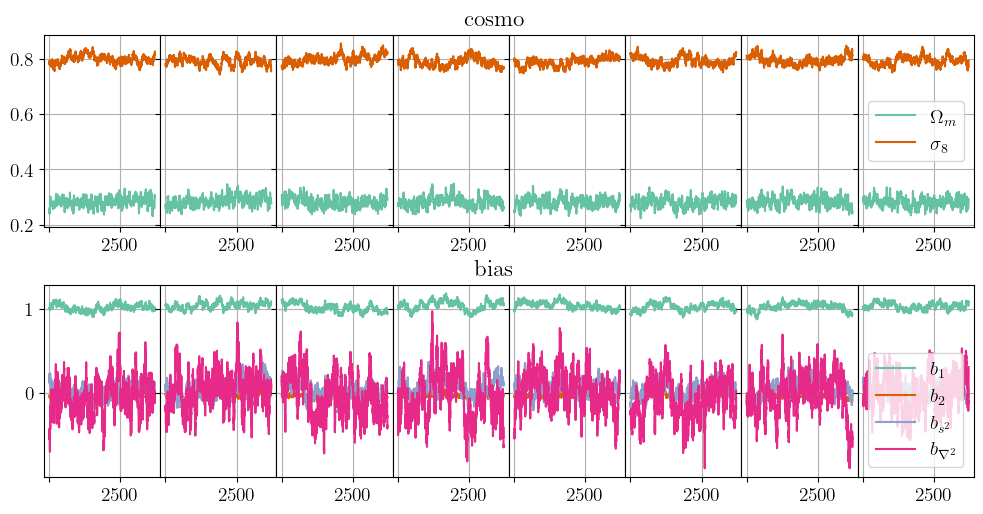

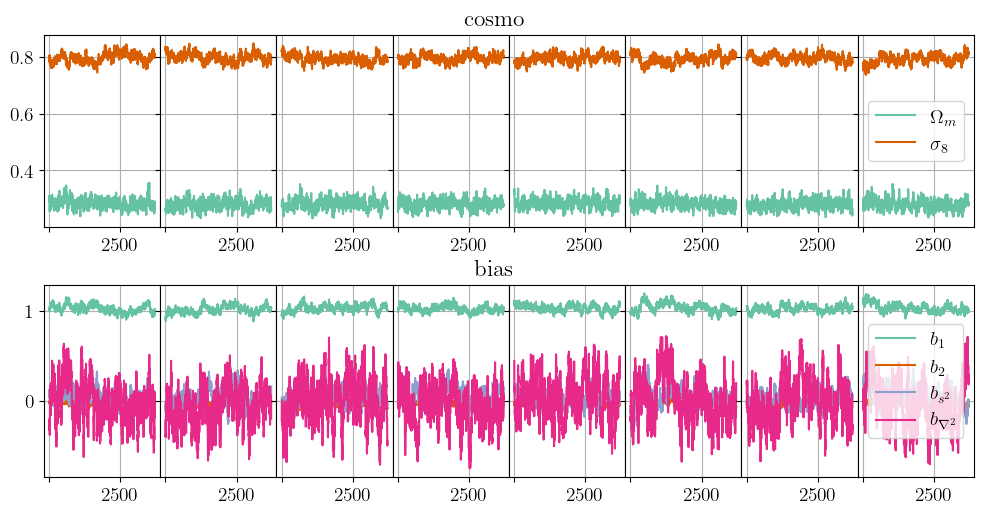

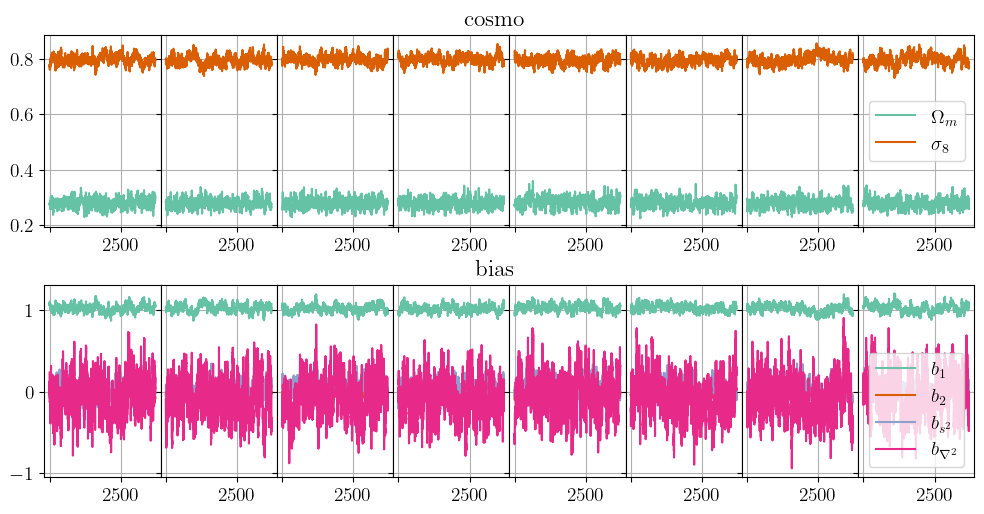

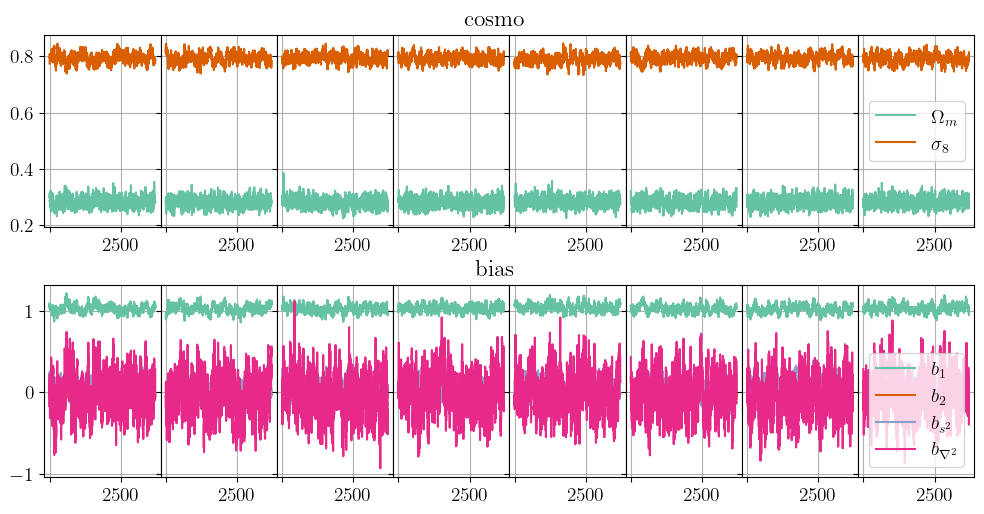

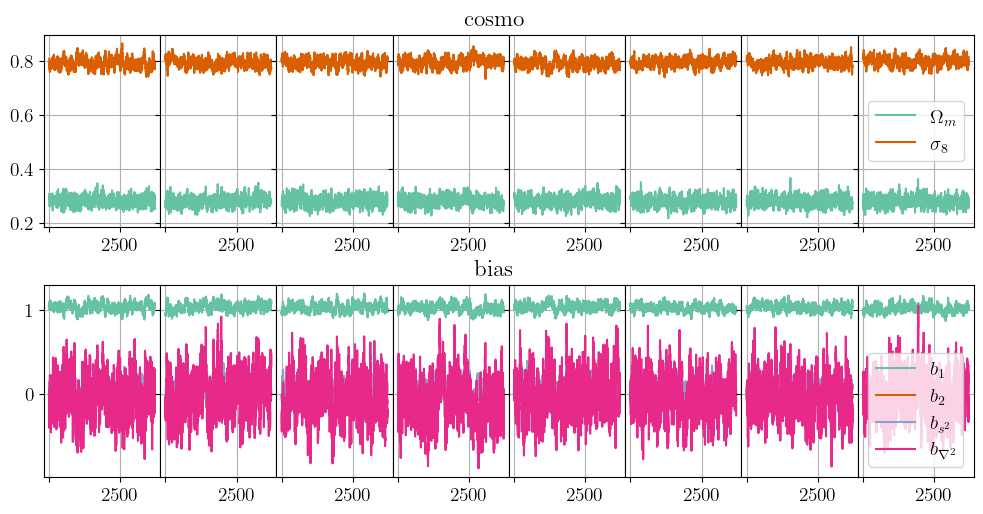

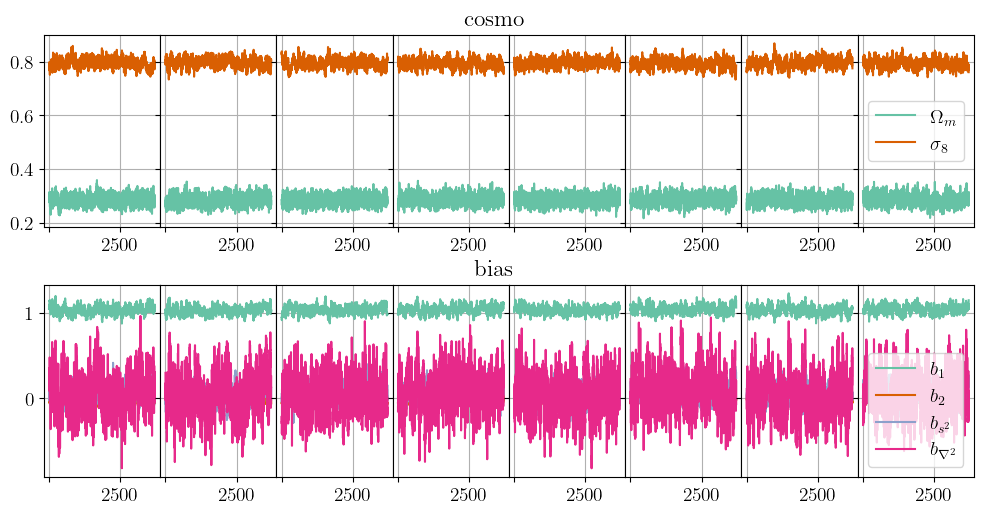

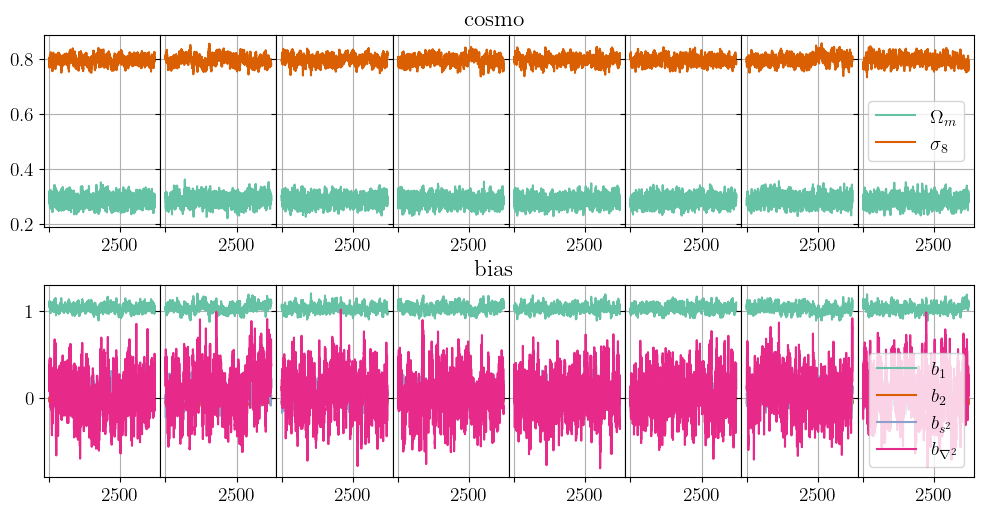

In [ ]:
from montecosmo.mcbench import Chains
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh, theme, SetDark2
theme(usetex=True, font_size=14)
groups = ['cosmo','bias','init']
# groups = ['cosmo_','bias_','init_']
group_names = ['cosmology', 'galaxy bias', 'linear field']

# pfx = 'volume_nbody_'
# pfx = 'evolution_nbody_'
# pfx = 'sampler_m64_1lpt_'
# pfx = 'precond_m64_1lpt_'

# sli = np.array([1,3,5,7])
sli = slice(0, 8)

tids = np.array([
        2040,2041,
        2140,2141,
        2240,2241,
        2340,2341,

        2301,2311,
        2321,2331,
        2201,2351,

        1222,2222,3222,4222,
        4112,4122,4222,
        ])[sli]
labels = np.array([
        "direct nomm", "direct mm",
        "fourier nomm", "fourier mm",
        "static nomm", "static mm",
        "dynamic nomm", "dynamic mm",

        "NUTS", "HMC",
        "NUTSwG", "NUTSwG2",
        "NUTS static", "aMCLMC",

        "m16 nbody", "m32 nbody", "m64 nbody", "m128 nbody", 
        "m128 1lpt", "m128 2lpt", "m128 nbody", 
           ])[sli]
ends = 10*[100]
starts = 10*[1]
# starts = np.array([1,1,1,1,1,1,1,1,1,1,1,1])[sli]


def from_id_(i_s, tid):
    model, mcmc_config, save_dir, save_path = from_id(tid)

    # sfx = 'volume/'
    # sfx = 'evolution/'
    # sfx = 'sampler/'
    sfx = 'precond/'

    # # if i_s in [0,1,3,4]:
    save_dir =  save_dir.replace('pickles/', 'pickles/' + sfx)
    save_path = save_path.replace('pickles/', 'pickles/' + sfx)

    model = FieldLevelModel.load(save_dir+"model.p")
    # print(model)
        
    return model, mcmc_config, save_dir, save_path 
    

moms = []
for i_s, (start, end, tid, lab) in enumerate(zip(starts, ends, tids, labels)):
    model, mcmc_config, save_dir, save_path = from_id_(i_s, tid)

    # # Load chains
    # thinning = 1
    # transforms = [
    #           lambda x:x[['*~diverging']],
    #           partial(Chains.thin, thinning=thinning),
    #           model.reparam_chains,
    #           partial(Chains.choice, n=10, names=['init','init_']),
    #             ]
    # chains = model.load_runs(save_path, start, end, transforms=transforms, batch_ndim=2)
    print(save_path)
    chains = pload(save_path+"_chains.p")[['*~kptc']]
    print(chains.shape, '\n')
    print(tree.map(lambda x: x.std(), chains))

    # Load last state
    if 'mse_per_dim' in chains:
        print("MSE per dim:", jnp.mean(chains.pop('mse_per_dim'), 1), '\n')

    # Plot chains
    plt.figure(figsize=(12,5))
    chains.flatten().plot(groups[:-1])
    # plt.savefig(save_dir+f'chains_{tid}.svg')
    chains.print_summary()
    
    # Compute moments
    # if i_s in [1,2]:
    mom = chains.stackby(groups).moment(axis=(0,1))
    moms.append(mom)

true_cmom = tree.map(lambda *x: jnp.stack(x), *moms)
true_cmom = true_cmom.moment(m=1, axis=0).center_moment()
print("centered moments:", true_cmom)

In [104]:
metrics = []
fin_metrics = []
gdsamps = []
kptcs = []
kptcs_obs = []
for i_s, (start, end, tid, lab) in enumerate(zip(starts, ends, tids, labels)):
    model, mcmc_config, save_dir, save_path = from_id_(i_s, tid)

    # Load truth
    print(f"Loading truth from {save_dir}")
    truth = pload(save_dir+"truth.p")
    mesh0 = jnp.fft.irfftn(truth['init_mesh'])
    pow0 = model.spectrum(mesh0)
    kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)

    # # Load chains
    # thinning = 1
    # transforms = [
    #             lambda x: x[['*~diverging']],
    #             partial(Chains.thin, thinning=thinning), 
    #             model.reparam_chains, 
    #             partial(model.powtranscoh_chains, mesh0=mesh0),
    #             partial(Chains.choice, n=10, names=['init','init_']),
    #             ]
    # chains = model.load_runs(save_path, start, end, transforms=transforms, batch_ndim=2)
    print(save_path)
    chains = pload(save_path+"_chains.p")[['*~mse_per_dim']]
    print(chains.shape, '\n')

    # Compute mesh statistics
    kptc = tree.map(jnp.concatenate, chains.pop('kptc'))
    kptcs.append(kptc)
    
    # Compute metrics
    ## ESS
    cumess = chains.stackby(groups).cumtrans(Chains.eval_per_ess, 50)
    metrics.append(cumess)

    cumess = chains.stackby(groups).eval_per_ess()
    ## MSEs
    # true_cmom = chains.stackby(groups).moment(axis=(0,1)).center_moment() # local truth
    cummse = chains.stackby(groups).eval_times_mse(true_cmom)
    fin_metric = tree.map(lambda x, y: jnp.concatenate((x[None], y)), cumess[['*~n_evals']], cummse[['*~n_evals']])
    fin_metrics.append(fin_metric)

    # Prepare KDE
    gdsamp = chains[groups[:-1]].to_getdist(lab)
    gdsamps.append(gdsamp)

True id: 3112040
Loading truth from /feynman/home/dphp/hs276503/scratch/pickles/precond/m64_b320.0_ao0.5_evlpt_lo1_pcdirect_obfield/
/feynman/home/dphp/hs276503/scratch/pickles/precond/m64_b320.0_ao0.5_evlpt_lo1_pcdirect_obfield/sMCLMC_nc8_ns128_nomm
{'Omega_m': (8, 3712), 'b1': (8, 3712), 'b2': (8, 3712), 'bn2': (8, 3712), 'bs2': (8, 3712), 'init_mesh': (8, 3712, 100), 'kptc': ((8, 3712, 15), (8, 3712, 15), (8, 3712, 15), (8, 3712, 15)), 'n_evals': (8, 3712), 'sigma8': (8, 3712)} 

Removed no burn in
True id: 3112041
Loading truth from /feynman/home/dphp/hs276503/scratch/pickles/precond/m64_b320.0_ao0.5_evlpt_lo1_pcdirect_obfield/
/feynman/home/dphp/hs276503/scratch/pickles/precond/m64_b320.0_ao0.5_evlpt_lo1_pcdirect_obfield/sMCLMC_nc8_ns128
{'Omega_m': (8, 3712), 'b1': (8, 3712), 'b2': (8, 3712), 'bn2': (8, 3712), 'bs2': (8, 3712), 'init_mesh': (8, 3712, 100), 'kptc': ((8, 3712, 15), (8, 3712, 15), (8, 3712, 15), (8, 3712, 15)), 'n_evals': (8, 3712), 'sigma8': (8, 3712)} 

Removed no

In [105]:
def plot_traj_fn(metrics, labels):
    i_start = 0
    styles = ['-', ':', '--']
    for i_m, (metric, meth) in enumerate(zip(metrics, labels)):
        for i_g, (st, g) in enumerate(zip(styles, groups)):
            plt.semilogy(metric['n_evals'][i_start:], metric[g][i_start:], st, c=SetDark2(i_m), label=g)

    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    handles = []
    for i_m, method in enumerate(labels):
        handles.append(Patch(color=SetDark2(i_m), label=method))
    for i_g, g in enumerate(groups):
        handles.append(Line2D([], [], color='grey', linestyle=styles[i_g], label=g))
    plt.legend(handles=handles, loc='lower right')

    plt.xlabel("$N_{\\mathrm{eval}}$")
    # plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;\\mathrm{ESS}$")
    plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$")

def plot_fin_all_fn(fin_metrics, labels):
    markers = ['D','s','o']
    ms = 10
    mec = 'w'
    ls = "-"
    lw = 2
    metric_names = [
                    # "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$",
                    "$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}[\\mu]$",
                    "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\mu]$",
                    "$N_{\\mathrm{eval}} \\times \\mathrm{MSE}[\\sigma]$"]
    

    axs = plt.gcf().subplots(1, len(groups), sharey='row')
    plt.gcf().subplots_adjust(wspace=0)
    for i_m, (metric, label) in enumerate(zip(fin_metrics, labels)):
        for i_g, (g, ax) in enumerate(zip(groups, axs)):

            # from matplotlib.transforms import ScaledTranslation
            # offset = lambda mm: ScaledTranslation(mm/25.4, 0, plt.gcf().dpi_scale_trans)
            # trans = ax.transData
            # xshifts = 5*np.array([-1,0,1])
            
            shifts = jnp.array([-1, 0, 1]) * .25
            for i_n, marker in enumerate(markers):
                # (marks, stemlines, baseline) = ax.stem(label, metric[g][i_n], markerfmt=marker,)
                (marks, stemlines, baseline) = ax.stem(i_m + shifts[i_n], metric[g][i_n], markerfmt=marker)
                plt.setp(marks, color=SetDark2(i_m), 
                         markersize=ms,  
                        #  transform=trans+offset(xshifts[i_n])
                        #  markeredgecolor=mec,
                         )
                plt.setp(stemlines, linestyle=ls, linewidth=lw, color=SetDark2(i_m),  
                        #  transform=trans+offset(xshifts[i_n]),
                         )
                ax.set_yscale('log')
                # ax.tick_params(axis='x', rotation=45)
                ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
                ax.set_title(group_names[i_g])
                enlarge = 0.6
                ax.set_xlim(-enlarge, len(labels)-1+enlarge)
                
    handles = []
    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    for i_m, label in enumerate(labels):
        handles.append(Patch(color=SetDark2(i_m), label=label))
    for i_m, (marker, name) in enumerate(zip(markers, metric_names)):
        handles.append(Line2D([], [], color='grey', marker=marker, label=name, 
                            linestyle="", markersize=ms, markeredgecolor=mec))
    plt.legend(handles=handles, loc="upper right")

def plot_fin_fn(fin_metrics, labels):
    markers = ['D','s','o']
    ms = 9
    mec = 'w'
    ls = "-"
    lw = 2  

    for i_m, (metric, label) in enumerate(zip(fin_metrics, labels)):
        for i_g, g in enumerate(groups):

            from matplotlib.transforms import ScaledTranslation
            offset = lambda mm: ScaledTranslation(mm/25.4, 0, plt.gcf().dpi_scale_trans)
            trans = plt.gca().transData
            xshifts = 8 * np.linspace(-1,1,len(labels))
            
            for i_n, marker in enumerate(markers[:1]):
                (marks, stemlines, baseline) = plt.stem(group_names[i_g], metric[g][i_n], markerfmt=marker,)
                plt.setp(marks, color=SetDark2(i_m), 
                         markersize=ms,  
                         transform=trans+offset(xshifts[i_m])
                        #  markeredgecolor=mec,
                         )
                plt.setp(stemlines, linestyle=ls, linewidth=lw, color=SetDark2(i_m),  
                         transform=trans+offset(xshifts[i_m]),
                         )
    plt.yscale('log')
    enlarge = 0.4
    plt.xlim(-enlarge, len(groups)-1+enlarge)
    plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$")
                
    handles = []
    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    for i_m, label in enumerate(labels):
        handles.append(Patch(color=SetDark2(i_m), label=label))
    plt.legend(handles=handles, loc="lower left", framealpha=1)
    # plt.legend(handles=handles, loc="upper right")


def plot_kptc(kptcs, labels):
    prob = 0.95
    log = False

    for kptc, label in zip(kptcs, labels):
        plot_powtranscoh(*jnp.median(jnp.stack(kptc), 1), log=log, label=label)
        plot_powtranscoh(*kptc, log=log, fill=prob)

    plt.subplot(131)
    plot_pow(*pow0, 'k', log=log, label='true')
    plot_pow(*kptc_obs[:2], ':', c='grey', log=log, label='obs')
    plt.legend()

    plt.subplot(133)
    plot_coh(kptc_obs[0], kptc_obs[-1], ':', log=log, c='grey', label='obs')

In [ ]:
def plot_fin_fn2(fin_metrics, labels):
    markers = ['D','D']
    ms = 9
    mecs = [None, 'w']
    ls = "-"
    lw = 2
    # labels = ['direct', 'fourier', 'kaiser static', 'kaiser dynamic']
    labels = ['real', 'fourier', 'kaiser static', 'kaiser dynamic']
    labels2 = ['no mass matrix', 'mass matrix']

    for i_m, label in enumerate(labels):
        for i_g, g in enumerate(groups):

            from matplotlib.transforms import ScaledTranslation
            offset = lambda mm: ScaledTranslation(mm/25.4, 0, plt.gcf().dpi_scale_trans)
            trans = plt.gca().transData
            xshifts = 8 * np.linspace(-1,1,len(labels))
            
            for i_n, (marker, mec) in enumerate(zip(markers, mecs)):
                metric = fin_metrics[2*i_m + i_n]
                (marks, stemlines, baseline) = plt.stem(group_names[i_g], metric[g][0], markerfmt=marker,)
                mec = SetDark2(i_m) if mec is None else mec
                plt.setp(marks, color=mec, 
                         markersize=ms,  
                         transform=trans+offset(xshifts[i_m]),
                         markeredgecolor=SetDark2(i_m),
                         )
                plt.setp(stemlines, linestyle=ls, linewidth=lw, color=SetDark2(i_m),  
                         transform=trans+offset(xshifts[i_m]),
                         )
    plt.yscale('log')
    enlarge = 0.4
    plt.xlim(-enlarge, len(groups)-1+enlarge)
    plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$")
                
    handles = []
    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    for i_m, label in enumerate(labels):
        handles.append(Patch(color=SetDark2(i_m), label=label))
    for i_m, (label2, mark, mec) in enumerate(zip(labels2[::-1], markers[::-1], mecs[::-1])):
        handles.append(Line2D([], [], linestyle='', color='grey' if mec is None else mec, 
                              marker=mark, markeredgecolor='grey', markersize=ms, label=label2))
    plt.legend(handles=handles, loc="lower left", framealpha=1)
    # plt.legend(handles=handles, loc="upper right")

precond_m64_1lpt_


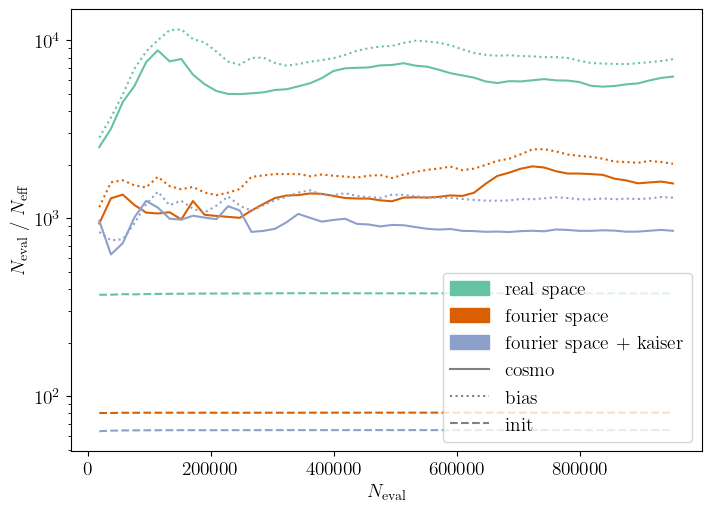

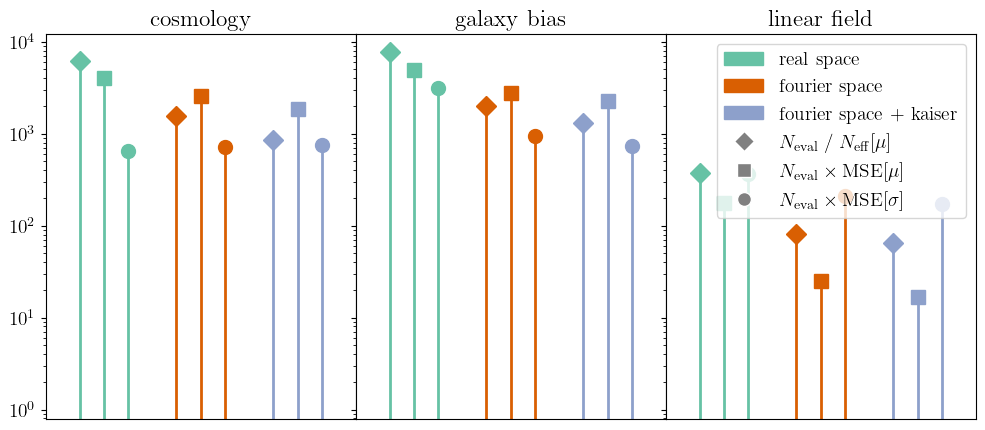

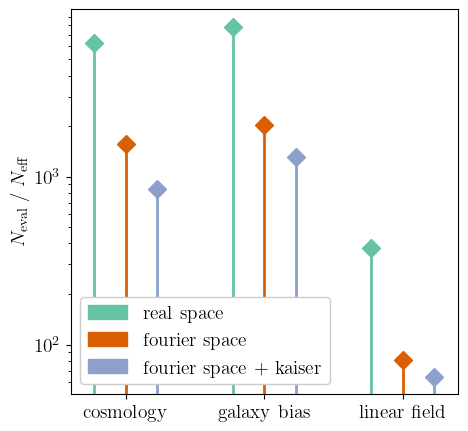

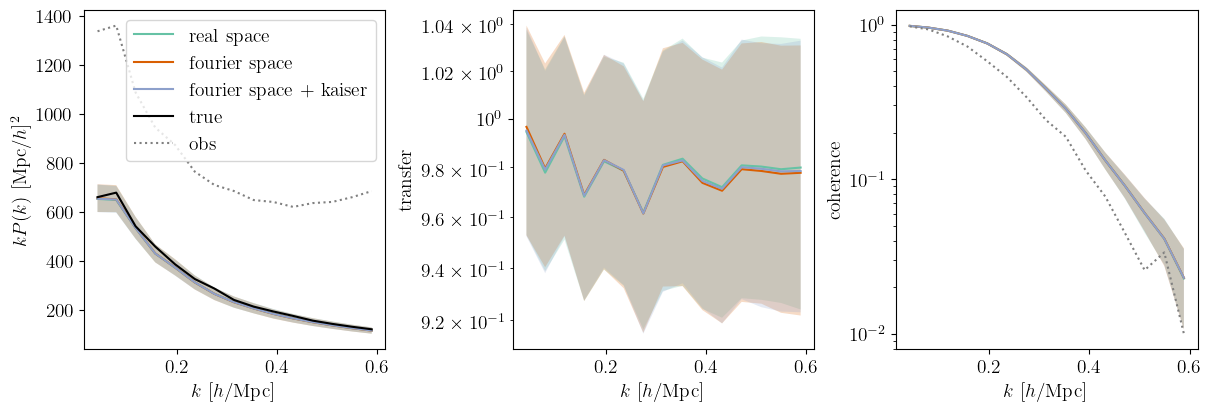

In [102]:
# Plot KDE, traj metrics, and final metrics
theme(usetex=True, font_size=14)
print(pfx)

plt.figure(figsize=(7, 5), layout="constrained")
plot_traj_fn(metrics, labels)
# plt.ylim(1e1,1e4)
plt.savefig(pfx+'cumess.pdf', bbox_inches='tight')

plt.figure(figsize=(12, 5))
plot_fin_all_fn(fin_metrics, labels)
# plt.ylim((5e1, 2e3))
plt.savefig(pfx+'fin_all_metrics.pdf', bbox_inches='tight')

plt.figure(figsize=(5, 5))
plot_fin_fn(fin_metrics, labels)
# plt.ylim((5e1, 2.3e2))
plt.savefig(pfx+'fin_metrics.pdf', bbox_inches='tight')

plt.figure(figsize=(12, 4), layout="constrained")
plot_kptc(kptcs, labels)
plt.savefig(pfx+'kptc.pdf', bbox_inches='tight')

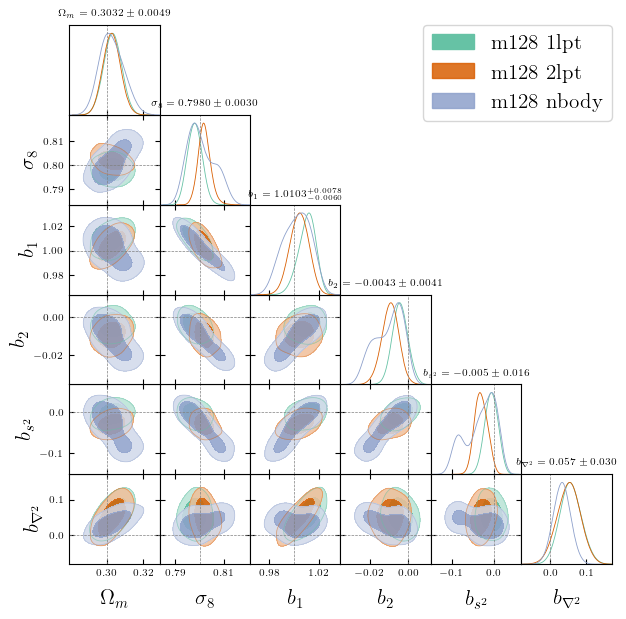

In [43]:
gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.settings.legend_fontsize = 20
gdplt.settings.axes_labelsize = 20
gdplt.settings.axes_fontsize = 12
# gdplt.settings.figure_legend_frame = False
# gdplt.settings.num_plot_contours = 3
gdplt.triangle_plot(roots=gdsamps,
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(i) for i in range(len(gdsamps))],
                legend_loc='upper right',)
plt.savefig(pfx+'triangle.pdf', bbox_inches='tight')

In [3]:
metrics = []
fin_metrics = []
gdsamps = []
kptcs = []
kptcs_obs = []
for i_s, (start, end, tid, lab) in enumerate(zip(starts, ends, tids, labels)):
    model, mcmc_config, save_dir, save_path = from_id_(i_s, tid)

    # Load truth
    print(f"Loading truth from {save_dir}")
    truth = pload(save_dir+"truth.p")
    mesh0 = jnp.fft.irfftn(truth['init_mesh'])
    pow0 = model.spectrum(mesh0)
    kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)

    # Load chains
    thinning = 1
    transforms = [
                lambda x: x[['*~diverging']],
                partial(Chains.thin, thinning=thinning),
                partial(Chains.moment, axis=1),
                lambda x: x[:,None]
                ]
    chains = model.load_runs(save_path, start, end, transforms=transforms, batch_ndim=2)
    print(chains.shape, '\n')
est_mom = chains.moment(m=1, axis=1).center_moment()

Loading truth from /feynman/home/dphp/hs276503/scratch/pickles/m32_b160.0_ao0.5_evlpt_lo1_pckaiser_obfield/
Loading: sMCLMC_nc4_ns64_nomm, from run 1 to run 100 (included)
File /feynman/home/dphp/hs276503/scratch/pickles/m32_b160.0_ao0.5_evlpt_lo1_pckaiser_obfield/sMCLMC_nc4_ns64_nomm_16.npz does not exist, stopping at run 15
{'Omega_m_': (4, 15, 3), 'b1_': (4, 15, 3), 'b2_': (4, 15, 3), 'bn2_': (4, 15, 3), 'bs2_': (4, 15, 3), 'init_mesh_': (4, 15, 32, 32, 32, 3), 'mse_per_dim': (4, 15, 3), 'n_evals': (4, 15), 'sigma8_': (4, 15, 3)} 



In [5]:
pth = '/feynman/home/dphp/hs276503/scratch/pickles/m32_b160.0_ao0.5_evlpt_lo1_pckaiser_obfield/sMCLMC_nc4_ns64_nomm_moment.p'
pdump(est_mom.data, pth)

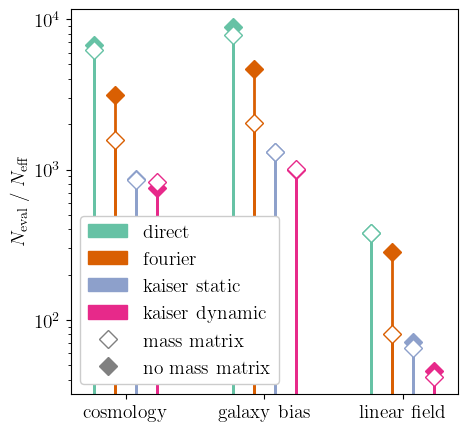

In [ ]:
plt.figure(figsize=(5, 5))
plot_fin_fn2(fin_metrics, labels)
plt.savefig(pfx+'fin_met.pdf', bbox_inches='tight')